In [ ]:
import os
import nltk
import importlib
import numpy as np
import pandas as pd
from gensim import corpora
import matplotlib.pyplot as plt
from validate_email import validate_email
from gensim.models.ldamodel import LdaModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# local imports
import src.utils
import src.plot_utils

importlib.reload(src.utils)
importlib.reload(src.plot_utils)

from src.plot_utils import plot_pie_chart, plot_bar_chart, plot_line_chart
from src.text_processing import remove_stop_words, tokenize_word, extract_email_organization

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

In [ ]:
columns = ['', 'headline', 'url', 'publisher', 'date', 'stock']
df = pd.read_csv('../data/raw/raw_analyst_ratings.csv')

# remove the first column as it is not needed
df = df.iloc[:, 1:]
df

In [ ]:
clean_data = './data/clean/raw_analyst_ratings.csv'
if os.path.exists(clean_data):
    os.remove(clean_data)
    print(f'{clean_data} has been deleted.')
else:
    print(f'{clean_data} doest not exist')

##  Descriptive Statistics

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df['headline_len'] = df['headline'].str.len()
df

In [ ]:
df['date'] = pd.to_datetime(df['date'], utc=True, format='mixed')
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day
df

In [ ]:
file_path = '../data/clean/raw_analyst_ratings.csv'

try:
    df.to_csv(file_path)
    print(f"File saved successfully at {file_path}")
except Exception as e:
    print(f"Failed to save file at {file_path}: {e}")

## Sentiment Analysis

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
# remove the stop words from the headline texts
df['cleaned_headline'] = df['headline'].apply(lambda x: remove_stop_words(x))

In [ ]:
# calculate the sentiment intensity scores for the cleaned headlines
df['sentiment_score'] = df['cleaned_headline'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [ ]:
CATEGORIES = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
bins = np.linspace(-1, 1, 6)

df['sentiment_categories'] = pd.cut(df['sentiment_score'], bins=bins, labels=CATEGORIES)

In [ ]:
sentiment_categories_count = df['sentiment_categories'].value_counts().reset_index()
sentiment_categories_count.columns = ['category', 'count']

sentiment_categories_count

In [ ]:
plot_pie_chart(sentiment_categories_count['count'], sentiment_categories_count['category'])

## Topic Modeling

In [ ]:
df['clean_headline_tokens'] = df['cleaned_headline'].apply(lambda x: tokenize_word(x))

In [ ]:
dictionary = corpora.Dictionary(df['clean_headline_tokens'])

In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in df['clean_headline_tokens']]

In [ ]:
num_topics = 3
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

In [ ]:
lda_model.print_topics()

## Time Series Analysis

In [ ]:
# show the publication trend for the years
df_by_year = df.groupby(['year']).size().reset_index()
df_by_year.columns = ['year', 'count']
df_by_year.set_index(df_by_year['year'], inplace=True)
df_by_year.drop(columns=['year'], inplace=True)
df_by_year

In [ ]:
x = df_by_year.index.values
y = df_by_year['count'].values

plot_line_chart(x, y)

In [ ]:
df_by_month = df.groupby(['year', 'month']).size().reset_index()
df_by_month.columns = ['year', 'month', 'count']
df_by_month

In [ ]:
# list the months in the year
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


def plot_for_year(selected_year: int) -> None:
    """
    Plots the number of news articles for each month in the given year.

    :param selected_year: The year for which the news counts are to be plotted.
    :type selected_year: int
    """
    news_counts = [0 for _ in range(12)]
    year_data = df_by_month[df_by_month['year'] == selected_year]

    for month, count in zip(year_data['month'], year_data['count']):
        idx = month - 1
        news_counts[idx] = count
    plot_line_chart(MONTHS, news_counts, figsize=(20, 8), title=f'News Articles Trends for {selected_year}')

In [ ]:
for year in df_by_month['year'].unique():
    plot_for_year(year)

In [ ]:
df_by_day = df.groupby(['year', 'month', 'day']).size().reset_index()
df_by_day.columns = ['year', 'month', 'day', 'count']
df_by_day

In [ ]:
def plot_for_month(selected_year: int, selected_month: int) -> None:
    news_counts = [0 for _ in range(31)]
    month_data = df_by_day[(df_by_day['year'] == selected_year) & (df_by_day['month'] == selected_month)]

    for day, count in zip(month_data['day'], month_data['count']):
        idx = day - 1
        news_counts[idx] = count
    plot_line_chart([str(i) for i in range(1, 32)], news_counts, figsize=(20, 8),
                    title=f'News Articles Trends for {MONTHS[selected_month - 1]} {selected_year}')

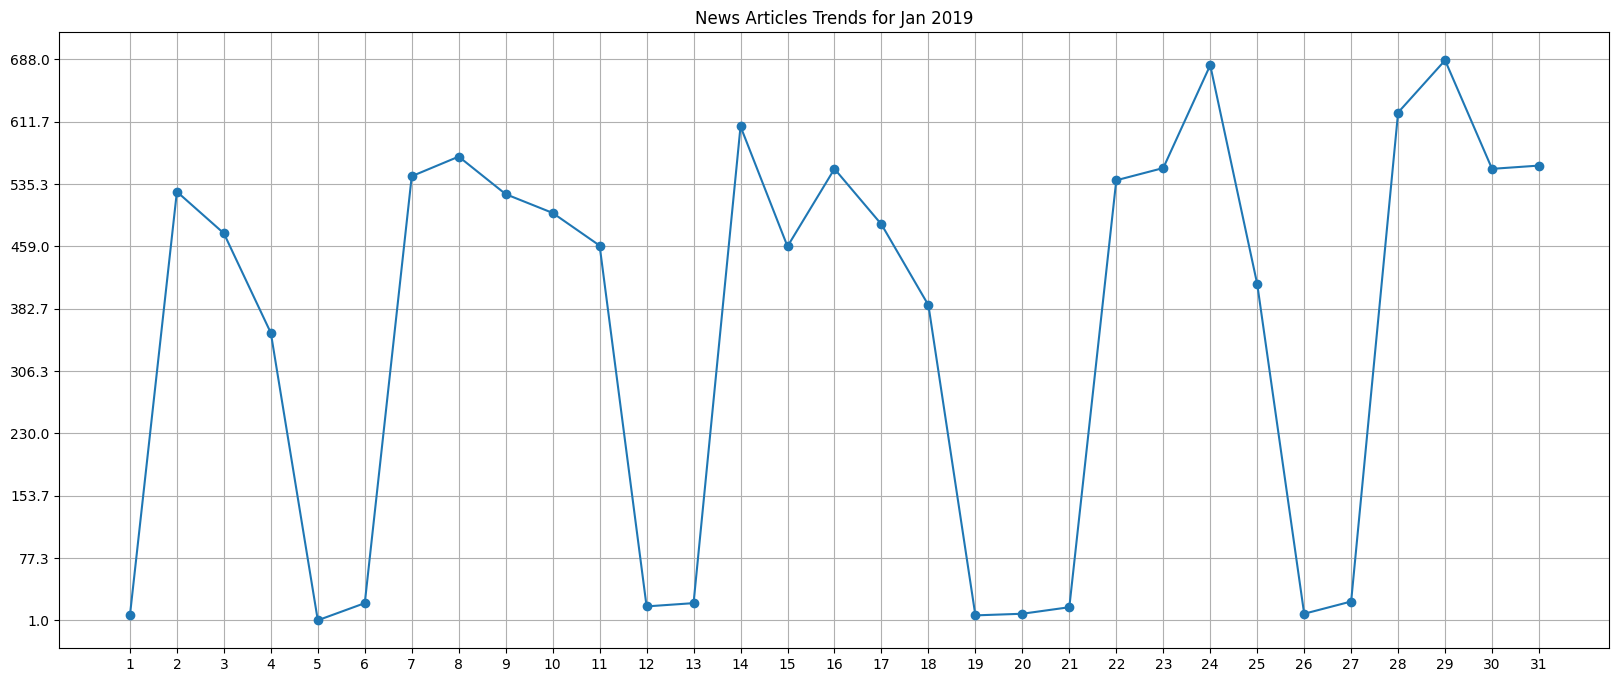

In [164]:
plot_for_month(2019, 1)

## Publisher Analysis

In [ ]:
df['publisher_is_email'] = df['publisher'].apply(lambda x: validate_email(x))
df

In [ ]:
email_df = df[df['publisher_is_email'] == True]
email_df

In [ ]:
email_df.loc[:, 'organization'] = email_df['publisher'].apply(lambda email: extract_email_organization(email))
email_df

In [ ]:
organization_count = email_df.groupby('organization').size().reset_index()
organization_count.columns = ['organization', 'count']
organization_count

In [ ]:
valuable_organization = organization_count[organization_count['count'] > 10]
plot_pie_chart(valuable_organization['count'], valuable_organization['organization'])

In [ ]:
plot_bar_chart(organization_count['organization'], organization_count['count'], figsize=(20, 8), color='gray',
               grid=True)